In [1]:
# This is a project on Brain Tumour Detection using Convolutional Neural Network
# Code by Chandru S - Feel free to use it!

In [1]:
!pip install tensorflow numpy opencv-python


In [3]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

# Install the Kaggle API
!pip install kaggle

# Create a directory for Kaggle configuration and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set the permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 92% 137M/149M [00:01<00:00, 130MB/s]
100% 149M/149M [00:01<00:00, 144MB/s]


In [4]:
!unzip brain-tumor-mri-dataset.zip -d /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0726.jpg  
  in

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split


dataset_path = '/content/dataset/Training'
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']


img_size = 224  # resize images to 224x224
data = []
labels = []

# load and preprocess the images
def load_data():
    for category in categories:
        path = os.path.join(dataset_path, category)
        class_num = categories.index(category)  # encoding
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))

                # grayscale
                gray_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

                # remove extra margins
                _, thresholded_img = cv2.threshold(gray_img, 45, 255, cv2.THRESH_BINARY)

                # get the bounding box
                contours, _ = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                x, y, w, h = cv2.boundingRect(contours[0])
                cropped_img = img_array[y:y+h, x:x+w]

                # resize the image
                resized_array = cv2.resize(cropped_img, (img_size, img_size))

                data.append(resized_array)
                labels.append(class_num)
            except Exception as e:
                pass

# Load the data
load_data()

# Convert data and labels to numpy arrays
data = np.array(data).astype('float32') / 255.0  # Normalize pixel values
labels = np.array(labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Print the shape of the datasets
print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Validation labels shape: {y_val.shape}')


Training data shape: (4569, 224, 224, 3)
Validation data shape: (1143, 224, 224, 3)
Training labels shape: (4569,)
Validation labels shape: (1143,)


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 25,636,868 (97.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 20% for validation

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/Training',
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/dataset/Training',
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    subset='validation'
)

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with data generators
history = model.fit(
    train_generator,
    epochs=50,  # You can adjust the number of epochs as needed
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

# Print final training and validation accuracy
print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


286/286 ━━━━━━━━━━━━━━━━━━━━ 149s 307ms/step - accuracy: 0.7417 - loss: 0.8797 - val_accuracy: 0.2314 - val_loss: 4.4717
Epoch 2/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 55s 191ms/step - accuracy: 0.8954 - loss: 0.3133 - val_accuracy: 0.2796 - val_loss: 1.8035
Epoch 3/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 52s 180ms/step - accuracy: 0.9185 - loss: 0.2092 - val_accuracy: 0.3085 - val_loss: 7.1013
Epoch 4/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 202ms/step - accuracy: 0.9405 - loss: 0.1841 - val_accuracy: 0.6635 - val_loss: 1.0813
Epoch 5/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 50s 174ms/step - accuracy: 0.9595 - loss: 0.1186 - val_accuracy: 0.6372 - val_loss: 1.3165
Epoch 6/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 95s 220ms/step - accuracy: 0.9706 - loss: 0.0896 - val_accuracy: 0.7949 - val_loss: 0.5871
Epoch 7/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 51s 176ms/step - accuracy: 0.9735 - loss: 0.0768 - val_accuracy: 0.2989 - val_loss: 13.2915
Epoch 8/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - accuracy: 0.9720 - loss: 0.0916 - v

In [5]:
#Evaluation of Model
# Paths to your test dataset folders
test_dataset_path = '/content/dataset/Testing'

# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=False
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')


Found 1311 images belonging to 4 classes.
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8816 - loss: 0.4196
Test Accuracy: 0.9199084639549255
Test Loss: 0.27727511525154114


In [6]:
model.save('final_brain_tumor_detection_model.keras')


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


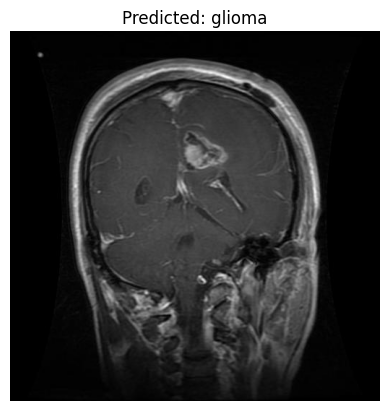

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


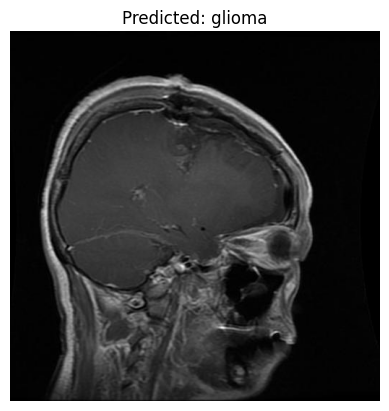

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


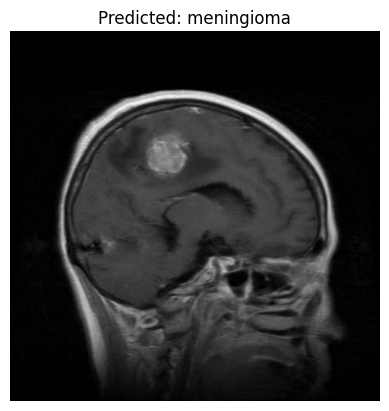

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


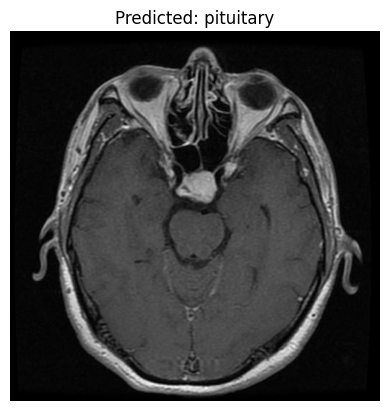

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


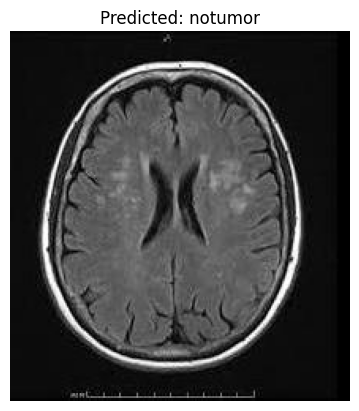

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


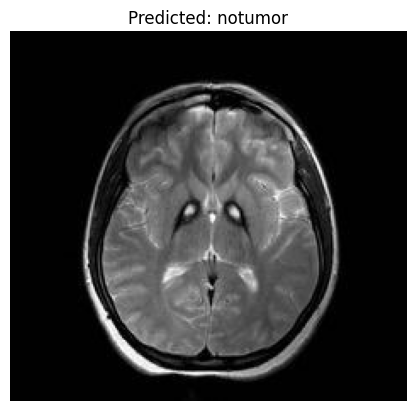

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


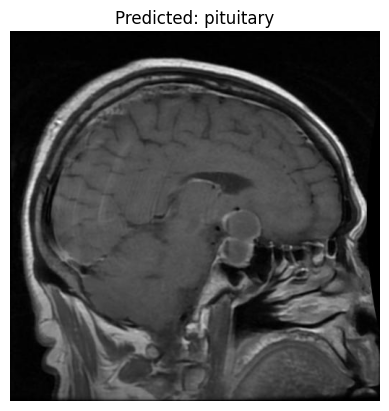

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


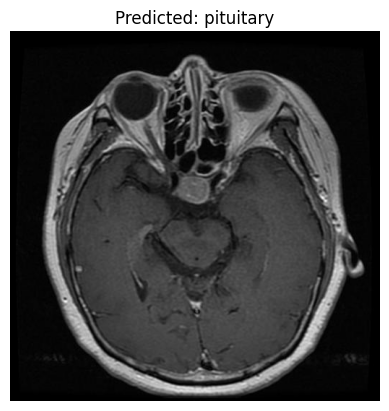

Image: /content/dataset/Testing/glioma/Te-gl_0128.jpg - Predicted Label: glioma
Image: /content/dataset/Testing/glioma/Te-gl_0181.jpg - Predicted Label: glioma
Image: /content/dataset/Testing/meningioma/Te-me_0236.jpg - Predicted Label: meningioma
Image: /content/dataset/Testing/meningioma/Te-me_0193.jpg - Predicted Label: pituitary
Image: /content/dataset/Testing/notumor/Te-no_0338.jpg - Predicted Label: notumor
Image: /content/dataset/Testing/notumor/Te-no_0047.jpg - Predicted Label: notumor
Image: /content/dataset/Testing/pituitary/Te-pi_0100.jpg - Predicted Label: pituitary
Image: /content/dataset/Testing/pituitary/Te-pi_0139.jpg - Predicted Label: pituitary


In [7]:
import matplotlib.pyplot as plt
import random

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to 224x224 pixels
    img = img.astype('float32') / 255.0  # Normalize pixel values
    return img

# Mapping of category indices to labels
category_labels = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Function to load, preprocess, and predict on test images
def predict_on_test_images(num_samples=2):
    test_images_path = '/content/dataset/Testing'
    predictions = []

    for category in categories:
        path = os.path.join(test_images_path, category)
        images = random.sample(os.listdir(path), num_samples)  # Randomly select num_samples images

        for img_name in images:
            img_path = os.path.join(path, img_name)
            img = load_and_preprocess_image(img_path)
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            # Make prediction
            pred = model.predict(img)
            predicted_class = np.argmax(pred)

            # Append the results
            predictions.append((img_path, category_labels[predicted_class]))

            # Display the image with prediction
            plt.imshow(cv2.imread(img_path))
            plt.title(f"Predicted: {category_labels[predicted_class]}")
            plt.axis('off')
            plt.show()

    return predictions

# Run the prediction function
predictions = predict_on_test_images()

# Print the predictions
for img_path, pred_label in predictions:
    print(f"Image: {img_path} - Predicted Label: {pred_label}")
